Import & Load Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('//content//PS_2025.12.01_05.00.30.csv', comment='#')
print("Dataset loaded:", df.shape)


Dataset loaded: (39119, 92)


Define Must-Have Features

In [ ]:
MUST_HAVE_FEATURES = [
    'pl_name','hostname','pl_rade','pl_bmasse','pl_eqt',
    'pl_orbper','pl_orbsmax','st_spectype','st_teff','st_met','st_rad'
]

print("Must-have features:", MUST_HAVE_FEATURES)


Must-have features: ['pl_name', 'hostname', 'pl_rade', 'pl_bmasse', 'pl_eqt', 'pl_orbper', 'pl_orbsmax', 'st_spectype', 'st_teff', 'st_met', 'st_rad']


Add Derived Features (pl_density & st_luminosity)

In [ ]:
df['pl_density'] = (df['pl_bmasse'] / (df['pl_rade'] ** 3)) * 5.514
T_sun = 5772
df['st_luminosity'] = (df['st_rad'] ** 2) * ((df['st_teff'] / T_sun) ** 4)

MUST_HAVE_FEATURES.extend(['pl_density', 'st_luminosity'])

print("Derived features added. New columns:", ['pl_density', 'st_luminosity'])


Derived features added. New columns: ['pl_density', 'st_luminosity']


In [ ]:
admin_cols = [
    'default_flag','pl_controv_flag','soltype','pl_refname','st_refname',
    'sy_refname','rowupdate','pl_pubdate','releasedate','rastr','decstr'
]

drop_admin = [c for c in admin_cols if c in df.columns and c not in MUST_HAVE_FEATURES]
df = df.drop(columns=drop_admin)

print("Admin cols removed:", drop_admin)
print("Remaining columns:", df.shape[1])


Admin cols removed: ['default_flag', 'pl_controv_flag', 'soltype', 'pl_refname', 'st_refname', 'sy_refname', 'rowupdate', 'pl_pubdate', 'releasedate', 'rastr', 'decstr']
Remaining columns: 83


Drop Duplicate Unit Columns

In [ ]:
dup_cols = []

if 'pl_radj' in df.columns:
    dup_cols += ['pl_radj','pl_radjerr1','pl_radjerr2','pl_radjlim']

if 'pl_bmassj' in df.columns:
    dup_cols += ['pl_bmassj','pl_bmassjerr1','pl_bmassjerr2','pl_bmassjlim']

dup_cols = [c for c in dup_cols if c in df.columns]
df = df.drop(columns=dup_cols)

print("Dropped duplicate unit columns:", dup_cols)


Dropped duplicate unit columns: ['pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim']


Drop >70% Missing Columns

In [ ]:
missing_pct = df.isnull().mean() * 100
high_miss = missing_pct[missing_pct > 70].index.tolist()
high_miss = [c for c in high_miss if c not in MUST_HAVE_FEATURES]

df = df.drop(columns=high_miss)

print("Dropped high-missing columns:", high_miss)
print("Remaining:", df.shape[1])


Dropped high-missing columns: ['pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassprov', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_eqterr1', 'pl_eqterr2']
Remaining: 65


In [ ]:
import pandas as pd

df = pd.read_csv("//content//exo_final_cleaned_dataset.csv")

# List all numeric columns to fill missing values with median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# List all categorical columns to fill missing values with mode
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

# Save the corrected file
df.to_csv("exo_final_cleaned_dataset_filled.csv", index=False)

print("Missing values fixed successfully!")
print("Remaining NULL count:", df.isna().sum().sum())


Missing values fixed successfully!
Remaining NULL count: 0


Variance Threshold Filter

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns
variances = df[num_cols].var()
low_var = [c for c in variances.index if variances[c] < 0.001 and c not in MUST_HAVE_FEATURES]

df = df.drop(columns=low_var)
num_cols = [c for c in num_cols if c not in low_var]

print("Dropped low variance features:", low_var)


Dropped low variance features: ['pl_orbperlim', 'pl_orbsmaxlim', 'pl_radelim', 'pl_insollim', 'pl_eqtlim', 'st_tefflim', 'st_radlim', 'st_masslim', 'st_metlim', 'st_logglim', 'sy_gaiamagerr1', 'sy_gaiamagerr2']


Pearson Correlation (>0.95)

In [ ]:
corr = df[num_cols].corr().abs()
high_corr = set()

for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if corr.iloc[i,j] > 0.95:
            c1 = corr.columns[i]
            c2 = corr.columns[j]
            if c1 in MUST_HAVE_FEATURES:
                high_corr.add(c2)
            elif c2 in MUST_HAVE_FEATURES:
                high_corr.add(c1)
            else:
                high_corr.add(c2)

df = df.drop(columns=list(high_corr))
num_cols = [c for c in num_cols if c not in high_corr]

print("Highly correlated dropped:", high_corr)


Highly correlated dropped: {'st_masserr2', 'pl_orbsmax', 'pl_orbpererr2', 'sy_gaiamag', 'pl_orbpererr1'}


In [ ]:
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=low, upper=high)

print("Outlier capping completed.")


Outlier capping completed.


In [ ]:
df.to_csv("exo_final_cleaned_dataset.csv", index=False)
print("Final dataset saved. Shape:", df.shape)


Final dataset saved. Shape: (39119, 48)


ONE-HOT ENCODING

In [ ]:
import pandas as pd


df = pd.read_csv("exo_final_cleaned_dataset_filled.csv")

print("🔍 Dataset Loaded:", df.shape)


categorical_cols = ['st_spectype', 'discoverymethod']

print("\n Categorical columns selected for One-Hot Encoding:")
print(categorical_cols)

print("\n Unique value counts:")
for col in categorical_cols:
    print(f" - {col}: {df[col].nunique()} unique categories")


df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

print("\n Shape before encoding:", df.shape)
print(" Shape after encoding:", df_encoded.shape)


print("\n One-Hot Columns Added:")
added_cols = [c for c in df_encoded.columns if any(col + "_" in c for col in categorical_cols)]
for col in added_cols:
    print(" -", col)


df_encoded.to_csv("exo_final_encoded_dataset.csv", index=False)

print("\n Saved as: exo_final_encoded_dataset.csv")


🔍 Dataset Loaded: (39119, 48)

 Categorical columns selected for One-Hot Encoding:
['st_spectype', 'discoverymethod']

 Unique value counts:
 - st_spectype: 289 unique categories
 - discoverymethod: 11 unique categories

 Shape before encoding: (39119, 48)
 Shape after encoding: (39119, 346)

 One-Hot Columns Added:
 - st_spectype_A
 - st_spectype_A0 V
 - st_spectype_A1 IV-V
 - st_spectype_A2
 - st_spectype_A2 V
 - st_spectype_A5
 - st_spectype_A5 V
 - st_spectype_A5-A6
 - st_spectype_A7 V
 - st_spectype_A8
 - st_spectype_A8 III
 - st_spectype_A8 V
 - st_spectype_A8Ve
 - st_spectype_A9/F0
 - st_spectype_Am C
 - st_spectype_B
 - st_spectype_B2 IV
 - st_spectype_B2.5 V
 - st_spectype_B9 IV
 - st_spectype_B9 V
 - st_spectype_B9 Vne
 - st_spectype_B9.5-A0
 - st_spectype_Be9.5/AO
 - st_spectype_DC
 - st_spectype_DQ
 - st_spectype_F
 - st_spectype_F V
 - st_spectype_F0
 - st_spectype_F0 IV
 - st_spectype_F1 V
 - st_spectype_F2
 - st_spectype_F2 V
 - st_spectype_F3
 - st_spectype_F3 V
 - st_s

In [ ]:
import pandas as pd
import re

df = pd.read_csv("exo_final_cleaned_dataset_filled.csv")

def extract_spectral(stype):
    if pd.isna(stype):
        return pd.Series([None, None, None])
    match = re.match(r"([OBAFGKM])\s*([0-9.]*)\s*([IV]{1,3}|V|III|IV|II|I)?", str(stype))
    if match:
        return pd.Series([match.group(1), match.group(2), match.group(3)])
    return pd.Series([None, None, None])

df[['spectral_class', 'spectral_subclass', 'luminosity_class']] = df['st_spectype'].apply(extract_spectral)

df['spectral_subclass'] = pd.to_numeric(df['spectral_subclass'], errors='coerce').fillna(df['spectral_subclass'].mode()[0])

df = df.drop(columns=['st_spectype'])

categorical_cols = ['spectral_class', 'luminosity_class', 'discoverymethod']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

df_encoded.to_csv("exo_final_encoded_dataset.csv", index=False)

print("Encoded shape:", df_encoded.shape)
print("Saved as exo_final_encoded_dataset.csv")


Encoded shape: (39119, 69)
Saved as exo_final_encoded_dataset.csv


In [ ]:
import pandas as pd

# load encoded dataset (missing pl_orbsmax)
df = pd.read_csv("//content//exo_final_encoded_dataset.csv")

# load original raw dataset (contains pl_orbsmax)
raw = pd.read_csv("//content//PS_2025.12.01_05.00.30.csv", comment='#')

# clean identifiers
df['pl_name'] = df['pl_name'].astype(str).str.strip().str.lower()
raw['pl_name'] = raw['pl_name'].astype(str).str.strip().str.lower()

# merge only pl_orbsmax column
df = df.merge(raw[['pl_name','pl_orbsmax']], on='pl_name', how='left')

df.to_csv("exo_final_cleaned_dataset_filled_fixed.csv", index=False)

print("✔ pl_orbsmax restored successfully!")
print("Missing pl_orbsmax after merge:", df['pl_orbsmax'].isna().sum())


✔ pl_orbsmax restored successfully!
Missing pl_orbsmax after merge: 170447


In [ ]:
import pandas as pd

df = pd.read_csv("//content//exo_final_cleaned_dataset_filled_fixed.csv")

median_value = df['pl_orbsmax'].median()
df['pl_orbsmax'] = df['pl_orbsmax'].fillna(median_value)

df.to_csv("exo_final_cleaned_dataset_filled_orbsmax.csv", index=False)

print("Missing values after fill:", df['pl_orbsmax'].isna().sum())


Missing values after fill: 0


In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv("//content//exo_final_cleaned_dataset_filled_orbsmax.csv")

num = df.select_dtypes(include=['float64','int64']).columns.tolist()

def safe_norm(series):
    mn = series.min()
    mx = series.max()
    if pd.isna(mn) or pd.isna(mx) or mx==mn:
        return pd.Series(np.zeros(len(series)), index=series.index)
    return (series - mn) / (mx - mn)

df['norm_pl_rade']  = safe_norm(df['pl_rade'])
df['norm_pl_bmasse']= safe_norm(df['pl_bmasse'])
df['norm_pl_eqt']   = safe_norm(df['pl_eqt'])
df['norm_pl_orbsmax']= safe_norm(df['pl_orbsmax'])
df['norm_pl_density']= safe_norm(df['pl_density'].fillna(df['pl_density'].median()))

earth_temp = 288.0
df['pl_temp_dev'] = (df['pl_eqt'] - earth_temp).abs()
df['norm_temp_dev'] = safe_norm(df['pl_temp_dev'])
df['n_temp'] = 1 - df['norm_temp_dev']

df['n_radius']  = 1 - (df['norm_pl_rade'] - safe_norm(pd.Series([1]))[0]).abs()
df['n_mass']    = 1 - (df['norm_pl_bmasse'] - safe_norm(pd.Series([1]))[0]).abs()
df['n_dist']    = 1 - (df['norm_pl_orbsmax'] - safe_norm(pd.Series([1]))[0]).abs()
df['n_density'] = 1 - (df['norm_pl_density'] - safe_norm(pd.Series([1]))[0]).abs()

df['habitability_score'] = (
      0.28 * df['n_temp']
    + 0.22 * df['n_radius']
    + 0.20 * df['n_mass']
    + 0.18 * df['n_dist']
    + 0.12 * df['n_density']
)

df['norm_st_teff'] = safe_norm(df['st_teff'])
df['norm_st_rad']  = safe_norm(df['st_rad'])
df['norm_st_met']  = safe_norm(df['st_met'].fillna(df['st_met'].median()))
df['norm_st_lum']  = safe_norm(df['st_luminosity'].fillna(df['st_luminosity'].median()))

df['stellar_compatibility'] = (
      0.40 * (1 - (df['norm_st_teff'] - safe_norm(pd.Series([5772]))[0]).abs())
    + 0.25 * (1 - (df['norm_st_rad']  - safe_norm(pd.Series([1]))[0]).abs())
    + 0.20 * df['norm_st_met']
    + 0.15 * (1 - (df['norm_st_lum'] - safe_norm(pd.Series([1]))[0]).abs())
)

df['habitability_score'] = df['habitability_score'].clip(0,1)
df['stellar_compatibility'] = df['stellar_compatibility'].clip(0,1)

df['exoplanet_habitability_index'] = 0.6 * df['habitability_score'] + 0.4 * df['stellar_compatibility']
df['exoplanet_habitability_index'] = df['exoplanet_habitability_index'].clip(0,1)

print("Features added:", ['habitability_score','stellar_compatibility','exoplanet_habitability_index'])
print("Top 10 planets by Exoplanet Habitability Index:")
display_df = df[['pl_name','hostname','habitability_score','stellar_compatibility','exoplanet_habitability_index']].sort_values('exoplanet_habitability_index', ascending=False).head(10)
print(display_df.to_string(index=False))

df.to_csv("exo_final_with_features.csv", index=False)
print("Saved: exo_final_with_features.csv")


Features added: ['habitability_score', 'stellar_compatibility', 'exoplanet_habitability_index']
Top 10 planets by Exoplanet Habitability Index:
     pl_name   hostname  habitability_score  stellar_compatibility  exoplanet_habitability_index
kepler-445 b Kepler-445            0.914647               0.946097                      0.927227
kepler-445 b Kepler-445            0.914647               0.946097                      0.927227
kepler-445 b Kepler-445            0.914647               0.946097                      0.927227
kepler-445 b Kepler-445            0.914647               0.946097                      0.927227
kepler-445 b Kepler-445            0.914647               0.946097                      0.927227
kepler-445 b Kepler-445            0.914647               0.946097                      0.927227
kepler-445 b Kepler-445            0.914647               0.946097                      0.927227
kepler-445 b Kepler-445            0.914647               0.946097              

Shape: (372065, 89)

Missing Values:
pl_name                         0
hostname                        0
sy_snum                         0
sy_pnum                         0
disc_year                       0
                               ..
norm_st_rad                     0
norm_st_met                     0
norm_st_lum                     0
stellar_compatibility           0
exoplanet_habitability_index    0
Length: 89, dtype: int64

Descriptive Statistics:
                                 count         mean        std          min  \
sy_snum                       372065.0     1.000000   0.000000     1.000000   
sy_pnum                       372065.0     1.921175   0.973411     1.000000   
disc_year                     372065.0  2014.862847   2.168170  2011.000000   
pl_orbper                     372065.0    17.593515  17.991942     0.090706   
pl_rade                       372065.0     2.588299   1.313364     0.270000   
...                                ...          ...        ...   

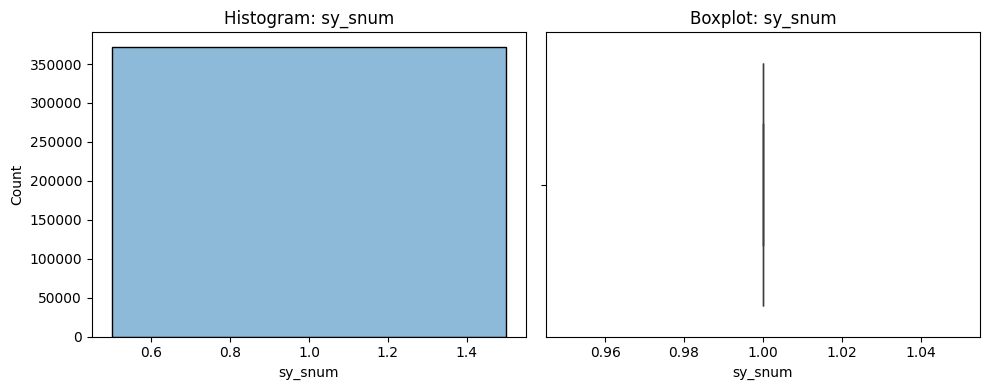

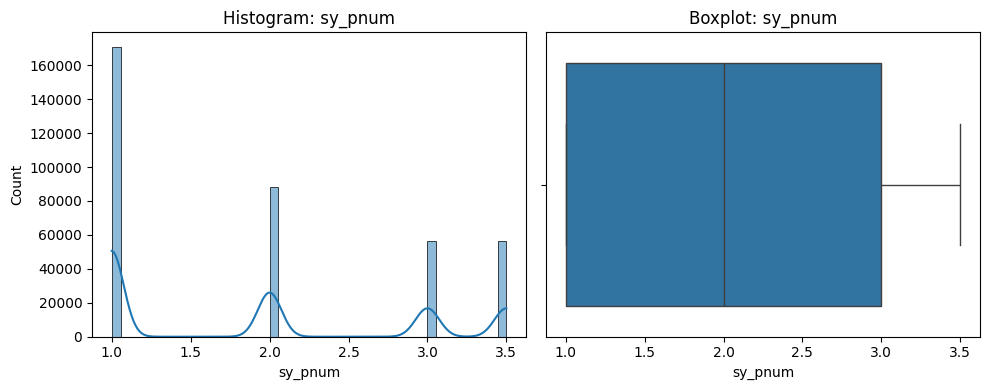

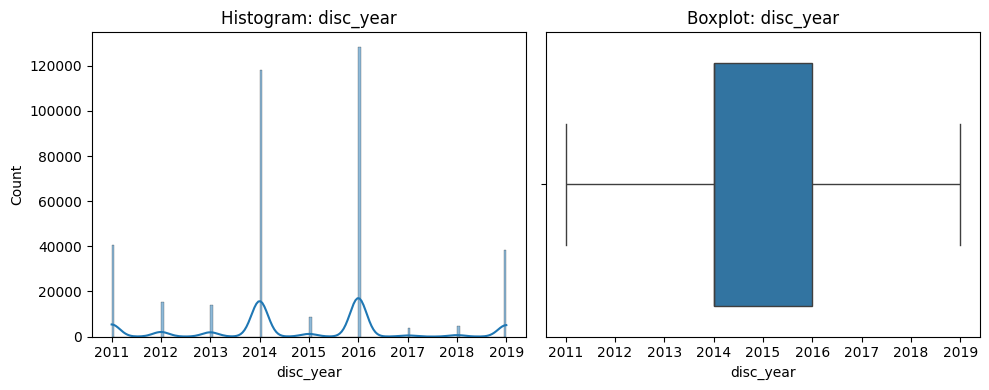

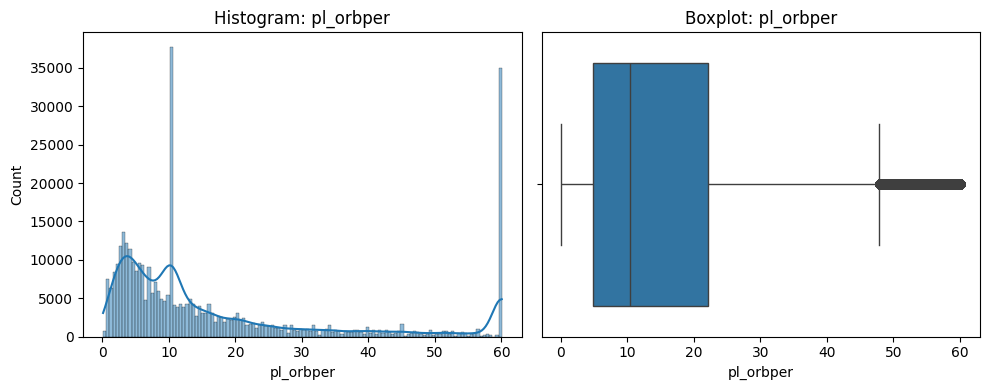

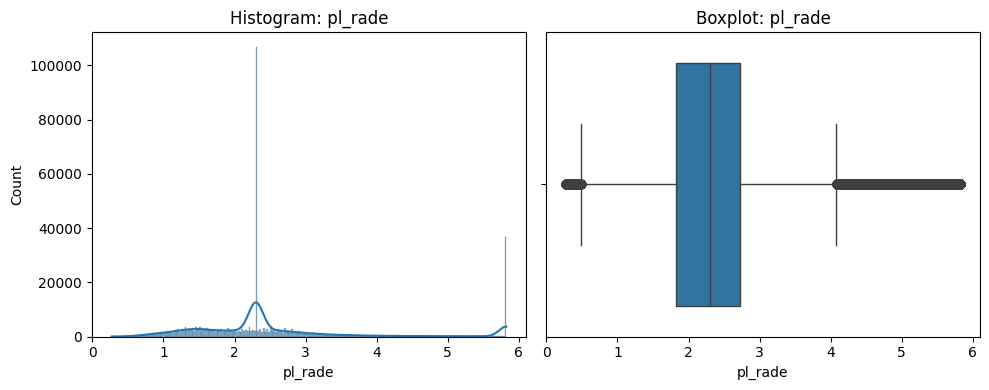

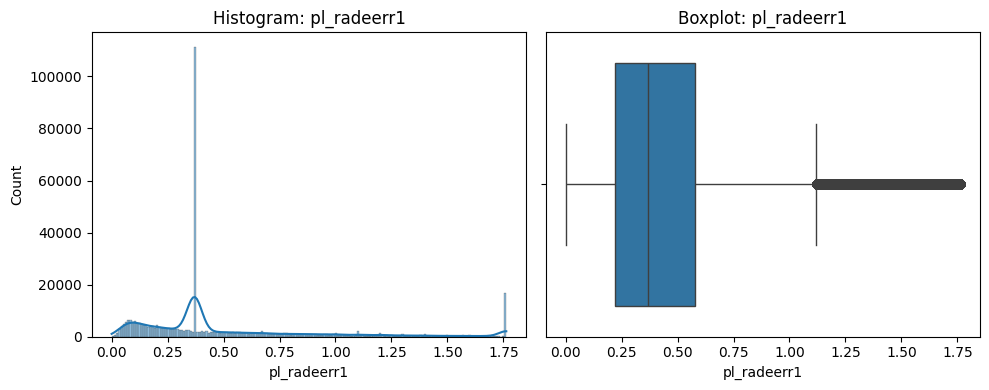

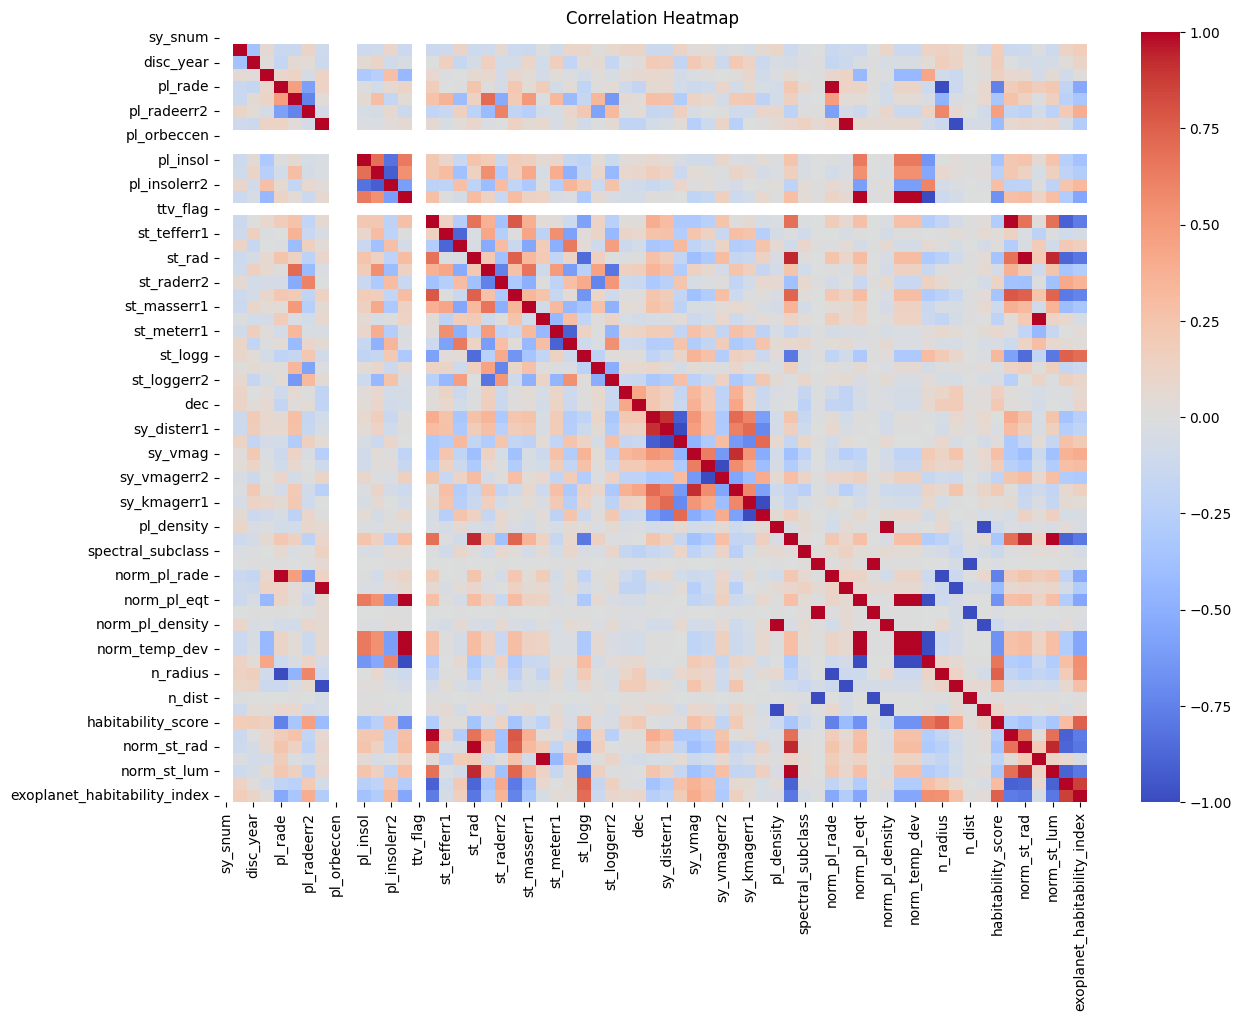

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("//content//exo_final_with_features.csv")

print("Shape:", df.shape)
print("\nMissing Values:")
print(df.isna().sum())

print("\nDescriptive Statistics:")
print(df.describe().T)

numeric_cols = df.select_dtypes(include=['float64','int64']).columns

for col in numeric_cols[:6]:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True)
    plt.title(f"Histogram: {col}")

    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14,10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', vmax=1, vmin=-1)
plt.title("Correlation Heatmap")
plt.show()


Outliers Before Cleaning:
{'sy_snum': np.int64(0), 'sy_pnum': np.int64(0), 'disc_year': np.int64(0), 'pl_orbper': np.int64(44539), 'pl_rade': np.int64(48669), 'pl_radeerr1': np.int64(38239), 'pl_radeerr2': np.int64(54695), 'pl_orbeccen': np.int64(0), 'pl_orbeccenlim': np.int64(0), 'pl_insolerr1': np.int64(162512), 'pl_insolerr2': np.int64(162446), 'ttv_flag': np.int64(0), 'st_tefferr1': np.int64(3026), 'st_tefferr2': np.int64(7600), 'st_raderr1': np.int64(25174), 'st_raderr2': np.int64(49226), 'st_masserr1': np.int64(36733), 'st_meterr1': np.int64(71766), 'st_meterr2': np.int64(93199), 'st_logg': np.int64(34037), 'st_loggerr1': np.int64(52141), 'st_loggerr2': np.int64(74430), 'sy_dist': np.int64(10688), 'sy_disterr1': np.int64(35329), 'sy_disterr2': np.int64(33772), 'sy_vmag': np.int64(14996), 'sy_vmagerr1': np.int64(20740), 'sy_vmagerr2': np.int64(20740), 'sy_kmag': np.int64(18994), 'sy_kmagerr1': np.int64(0), 'sy_kmagerr2': np.int64(0), 'spectral_subclass': np.int64(10830), 'pl_orbsm

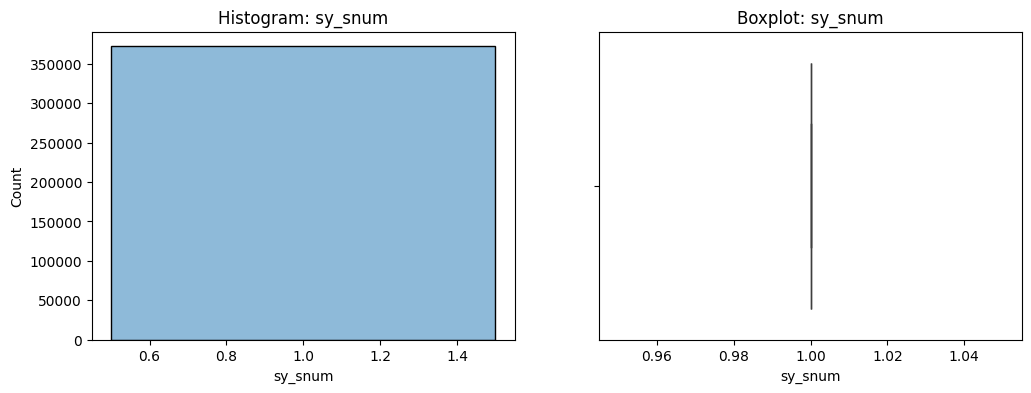

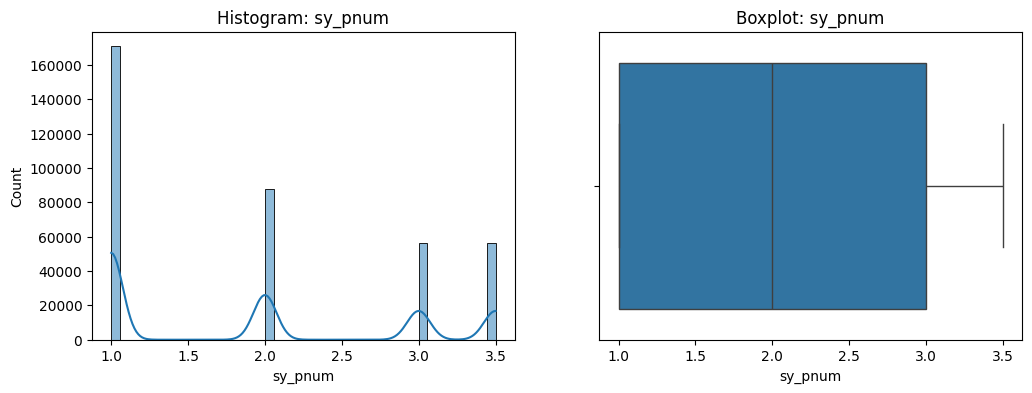

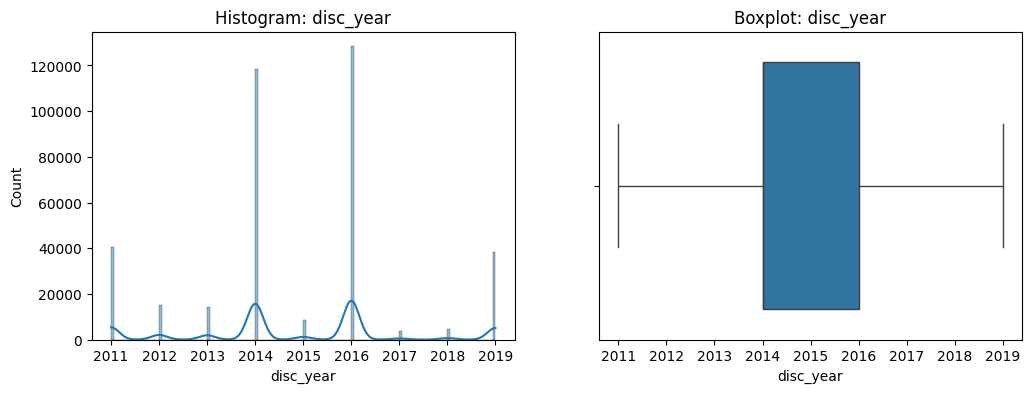

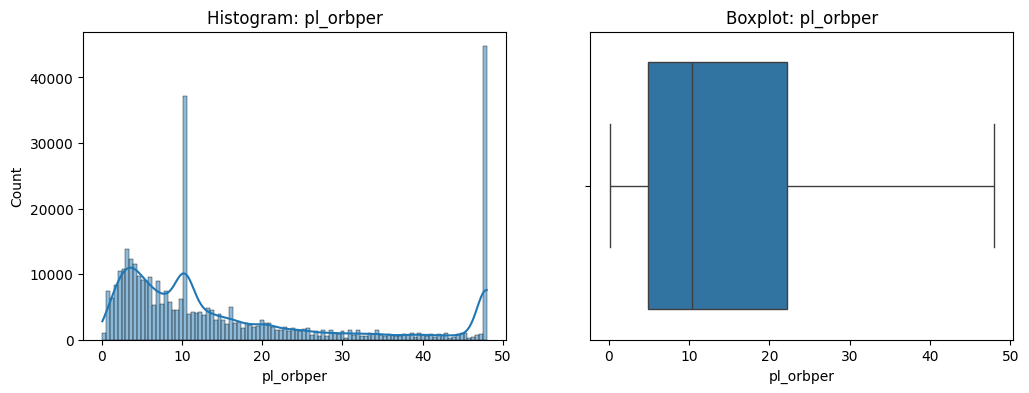

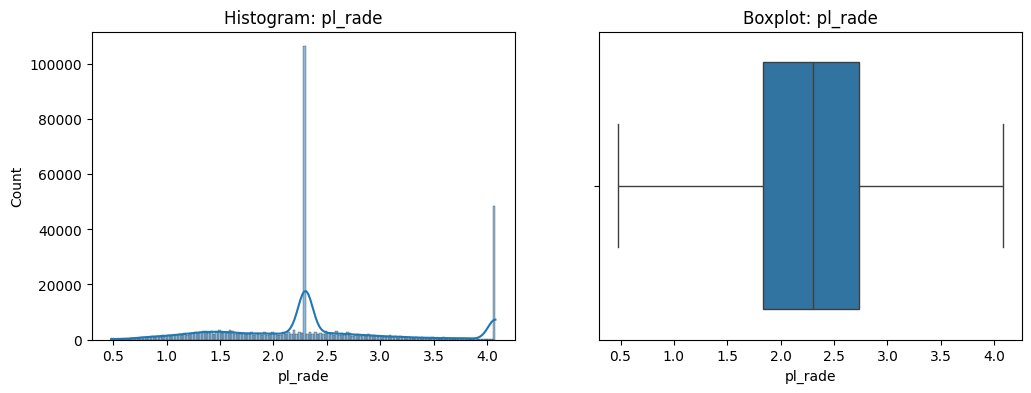

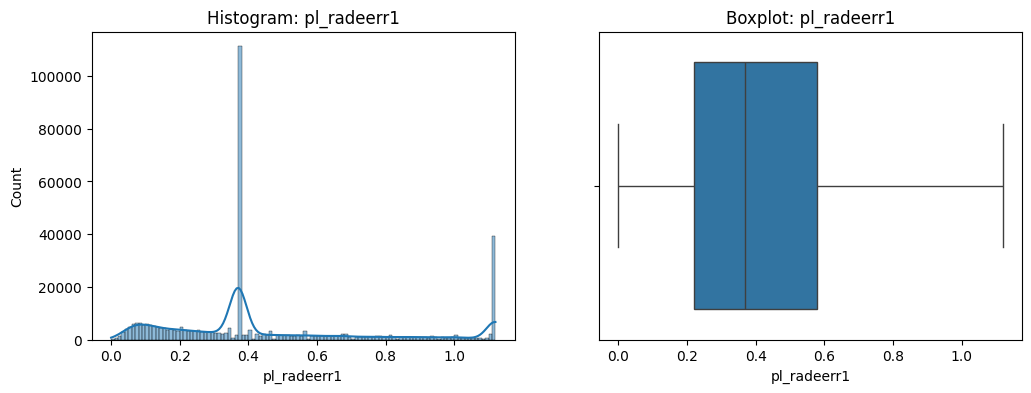


Saved cleaned dataset as exo_final_outlier_cleaned_dataset.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("//content//exo_final_with_features.csv")

numeric_cols = df.select_dtypes(include=[np.number]).columns

ignore_cols = [
    'st_teff','st_rad','st_mass','st_luminosity','st_met','pl_insol',
    'pl_bmasse','pl_density','pl_eqt','ra','dec'
]

cap_cols = [c for c in numeric_cols if c not in ignore_cols]

def cap_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return np.clip(series, lower, upper)

before_outliers = {}
after_outliers = {}

for col in cap_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    before_outliers[col] = ((df[col] < lower) | (df[col] > upper)).sum()
    df[col] = cap_iqr(df[col])
    after_outliers[col] = ((df[col] < lower) | (df[col] > upper)).sum()

print("Outliers Before Cleaning:")
print(before_outliers)

print("\nOutliers After Cleaning:")
print(after_outliers)

for col in cap_cols[:6]:
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df[col], kde=True, ax=ax[0])
    ax[0].set_title(f"Histogram: {col}")
    sns.boxplot(x=df[col], ax=ax[1])
    ax[1].set_title(f"Boxplot: {col}")
    plt.show()

df.to_csv("exo_final_outlier_cleaned_dataset.csv", index=False)
print("\nSaved cleaned dataset as exo_final_outlier_cleaned_dataset.csv")
